In [1]:
import os
# os.environ['JAX_PLATFORMS']="cpu"


import sys
sys.path.append("./src")

from flax import nnx
import jax 
import jax.numpy as jnp
import optax
import numpy as np

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

import time
import diffrax

In [2]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial

@partial(jax.jit, static_argnums=[1,2,3])  # type: ignore
def make_moons_jax(key, n_samples=100, shuffle=True, noise=None):
    """Make two interleaving half circles using JAX.

    Args:
        n_samples: The total number of points generated.
        shuffle: Whether to shuffle the samples.
        noise: Standard deviation of Gaussian noise added to the data.
        random_state: A JAX random.PRNGKey for reproducibility.

    Returns:
        X: A JAX array of shape (n_samples, 2) containing the generated samples.
        y: A JAX array of shape (n_samples,) containing the integer labels (0 or 1)
           for class membership of each sample.
    """

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Generate points for the outer moon (label 0)
    outer_circ_t = random.uniform(key, shape=(n_samples_out,)) * jnp.pi
    key, subkey = random.split(key)
    outer_circ_x = jnp.cos(outer_circ_t)
    outer_circ_y = jnp.sin(outer_circ_t)
    X_outer = jnp.vstack([outer_circ_x, outer_circ_y]).T

    # Generate points for the inner moon (label 1)
    inner_circ_t = random.uniform(subkey, shape=(n_samples_in,)) * jnp.pi
    key, subkey = random.split(key)
    inner_circ_x = 1 - jnp.cos(inner_circ_t)
    inner_circ_y = 0.5 - jnp.sin(inner_circ_t)
    X_inner = jnp.vstack([inner_circ_x, inner_circ_y]).T

    # Combine the moons
    X = jnp.vstack([X_outer, X_inner])
    y = jnp.hstack([jnp.zeros(n_samples_out, dtype=jnp.int32), jnp.ones(n_samples_in, dtype=jnp.int32)])

    if noise is not None:
        # Add Gaussian noise
        key, subkey = random.split(key)
        X += random.normal(subkey, shape=X.shape) * noise

    if shuffle:
        # Shuffle the data
        key, subkey = random.split(key)
        permutation = random.permutation(subkey, n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y

In [3]:
@partial(jax.jit, static_argnums=[1])  # type: ignore
def inf_train_gen(key, batch_size: int = 200):
    x = make_moons_jax(key, batch_size, shuffle=True, noise=0.1)[0]

    return x

In [4]:
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

In [ ]:
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array):
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
 
        t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        # x = self.bn1(x)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        # x = self.bn2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        # x = self.bn3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        # x = self.bn4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [6]:
# training arguments
lr = 0.001
iterations = 50001
print_every = 2000
hidden_dim = 512

# velocity field model init
vf = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

# init optimizer
optimizer = nnx.Optimizer(vf, optax.adam(lr))

In [7]:
batch_size = 128

In [8]:
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

def loss_fn(vf, batch):
    path_sample = path.sample(*batch)
    return jnp.mean(jnp.square(vf(path_sample.x_t, path_sample.t) - path_sample.dx_t))

@nnx.jit
def train_step(vf, optimizer, batch):
    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(vf, batch)
    optimizer.update(grads)  # In-place updates.

    return loss

In [9]:
start_time = time.time()
key = jax.random.PRNGKey(0)
for i in range(iterations):
    key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
    x_1 = inf_train_gen(subkey1, batch_size=batch_size) # sample data
    x_0 = jax.random.normal(subkey2, x_1.shape)
    t = jax.random.uniform(subkey3, x_1.shape[0])

    batch = (x_0, x_1, t)
    loss = train_step(vf, optimizer, batch)  # update model parameters

    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
              .format(i+1, elapsed*1000/print_every, loss.item()))
        start_time = time.time()

E0506 17:40:51.556399   40649 buffer_comparator.cc:157] Difference at 33: 0, expected -0.153091
E0506 17:40:51.556475   40649 buffer_comparator.cc:157] Difference at 35: 0, expected -0.123086
E0506 17:40:51.556481   40649 buffer_comparator.cc:157] Difference at 37: 0, expected -0.162481
E0506 17:40:51.556484   40649 buffer_comparator.cc:157] Difference at 39: 0, expected -0.158354
E0506 17:40:51.556487   40649 buffer_comparator.cc:157] Difference at 40: 0, expected 0.115122
E0506 17:40:51.556489   40649 buffer_comparator.cc:157] Difference at 41: 0, expected -0.142899
E0506 17:40:51.556492   40649 buffer_comparator.cc:157] Difference at 43: 0, expected -0.137436
E0506 17:40:51.556495   40649 buffer_comparator.cc:157] Difference at 45: 0, expected -0.13804
E0506 17:40:51.556498   40649 buffer_comparator.cc:157] Difference at 46: 0, expected 0.11546
E0506 17:40:51.556501   40649 buffer_comparator.cc:157] Difference at 47: 0, expected -0.135819
2025-05-06 17:40:51.556527: E external/xla/x

| iter   2000 |  5.17 ms/step | loss    0.996 
| iter   4000 |  2.31 ms/step | loss    1.158 
| iter   6000 |  2.22 ms/step | loss    1.120 
| iter   8000 |  2.32 ms/step | loss    0.949 
| iter  10000 |  2.50 ms/step | loss    0.975 
| iter  12000 |  2.30 ms/step | loss    1.152 
| iter  14000 |  2.20 ms/step | loss    1.110 
| iter  16000 |  2.17 ms/step | loss    0.964 
| iter  18000 |  2.15 ms/step | loss    1.167 
| iter  20000 |  2.15 ms/step | loss    0.910 
| iter  22000 |  2.17 ms/step | loss    0.838 
| iter  24000 |  2.16 ms/step | loss    0.985 
| iter  26000 |  2.16 ms/step | loss    1.002 
| iter  28000 |  2.21 ms/step | loss    0.941 
| iter  30000 |  2.16 ms/step | loss    0.977 
| iter  32000 |  2.14 ms/step | loss    0.979 
| iter  34000 |  2.15 ms/step | loss    0.984 
| iter  36000 |  2.14 ms/step | loss    0.967 
| iter  38000 |  2.12 ms/step | loss    0.911 
| iter  40000 |  2.12 ms/step | loss    1.188 
| iter  42000 |  2.12 ms/step | loss    0.788 
| iter  44000

In [10]:
vf.eval()

In [11]:
vf(x_1, 1.0).shape

(128, 2)

In [12]:
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
# eps_time = 1e-2
T = jnp.linspace(0,1,10)  # sample times

# x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))  # initial conditions
solver = ODESolver(velocity_model=vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='dopri5', step_size=step_size, return_intermediates=True)

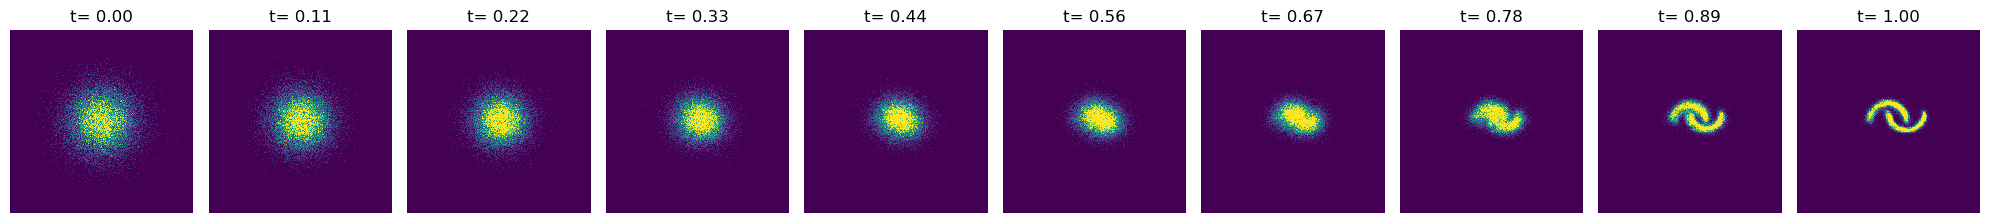

In [13]:
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()